In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from faker import Faker
from matplotlib.lines import Line2D

In [2]:
# Initialize Faker for generating mock data
fake = Faker()

# --- 1. DATA SIMULATION ---
def simulate_ambidextrous_data(num_employees=200):
    """
    Simulates employee, performance, and collaboration data for a large
    international healthcare corporation with distinct exploratory and exploitative units.
    """
    print("Step 1: Simulating corporate data...")
    departments = {
        'R&D': 'Exploratory',
        'Clinical Trials': 'Exploratory',
        'Manufacturing': 'Exploitative',
        'Quality Assurance': 'Exploitative',
        'Marketing': 'Exploitative',
        'Sales': 'Exploitative',
        'Strategy': 'Integration' # A special department for bridging
    }
    roles_by_dept = {
        'R&D': ['Research Scientist', 'Lab Technician', 'Chemist'],
        'Clinical Trials': ['Clinical Coordinator', 'Data Analyst'],
        'Manufacturing': ['Process Engineer', 'Supply Chain Manager'],
        'Quality Assurance': ['QA Specialist', 'Compliance Officer'],
        'Marketing': ['Product Manager', 'Market Analyst'],
        'Sales': ['Sales Rep', 'Account Manager'],
        'Strategy': ['Corporate Strategist', 'Liaison Officer']
    }
    locations = ['USA', 'Germany', 'Japan', 'Switzerland', 'UK']

    employee_data = []
    for i in range(num_employees):
        dept = np.random.choice(list(departments.keys()))
        employee_type = departments[dept]
        role = np.random.choice(roles_by_dept[dept])
        
        # Assign activities based on employee type
        exploit_activities = np.random.randint(0, 5) if employee_type == 'Exploratory' else np.random.randint(5, 11)
        explore_activities = np.random.randint(5, 11) if employee_type == 'Exploratory' else np.random.randint(0, 5)
        
        # Integration roles have a mix
        if employee_type == 'Integration':
             exploit_activities = np.random.randint(3, 8)
             explore_activities = np.random.randint(3, 8)

        # Assign performance metrics
        efficiency_score = np.random.normal(loc=8.5, scale=1) if employee_type == 'Exploitative' else np.random.normal(loc=5, scale=1.5)
        innovation_score = np.random.normal(loc=8.5, scale=1) if employee_type == 'Exploratory' else np.random.normal(loc=5, scale=1.5)
        if employee_type == 'Integration':
            efficiency_score = np.random.normal(loc=7, scale=1)
            innovation_score = np.random.normal(loc=7, scale=1)

        employee_data.append({
            'EmployeeID': 1000 + i,
            'Name': fake.name(),
            'Department': dept,
            'Role': role,
            'Type': employee_type,
            'Location': np.random.choice(locations),
            'Exploitative_Activities': exploit_activities,
            'Exploratory_Activities': explore_activities,
            'Efficiency_Score': round(np.clip(efficiency_score, 1, 10), 2),
            'Innovation_Score': round(np.clip(innovation_score, 1, 10), 2)
        })
    df = pd.DataFrame(employee_data)

    # Simulate collaboration network
    num_collaborations = 400
    collaborations = []
    for _ in range(num_collaborations):
        # Encourage cross-functional collaboration via Strategy team
        if np.random.rand() < 0.3:
            p1_df = df[df['Department'] == 'Strategy']
            if not p1_df.empty:
                p1 = p1_df.sample(1)['EmployeeID'].iloc[0]
                p2_dept = np.random.choice(['R&D', 'Sales', 'Manufacturing'])
                p2_df = df[df['Department'] == p2_dept]
                if not p2_df.empty:
                    p2 = p2_df.sample(1)['EmployeeID'].iloc[0]
                    collaborations.append((p1, p2))
        else:
            if len(df['EmployeeID']) >= 2:
                p1, p2 = np.random.choice(df['EmployeeID'], 2, replace=False)
                collaborations.append((p1, p2))

    print("✅ Data simulation complete.\n")
    return df, collaborations

In [3]:
# --- 2. DATA MINING AND ANALYSIS ---

def analyze_role_differentiation(df):
    """
    Uses K-Means clustering to project and validate the differentiation
    between exploitative and exploratory roles based on activity data.
    """
    print("Step 2: Projective Differentiation Analysis...")
    features = df[['Exploitative_Activities', 'Exploratory_Activities']]
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    df['Cluster'] = kmeans.fit_predict(scaled_features)

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df,
        x='Exploitative_Activities',
        y='Exploratory_Activities',
        hue='Cluster',
        palette='viridis',
        style='Type',
        s=100
    )
    plt.title('Projective Differentiation of Roles via Clustering', fontsize=16)
    plt.xlabel('Engagement in Exploitative Activities')
    plt.ylabel('Engagement in Exploratory Activities')
    plt.grid(True)
    plt.legend(title='Assigned Cluster & True Type')
    plt.savefig('differentiation_clusters.png')
    
    print("✅ Clustering complete. See 'differentiation_clusters.png'.")
    
    # --- IMPROVEMENT 1: Add Cluster Statistics ---
    print("\n--- Cluster Statistics ---")
    # Identify which cluster maps to which type
    exploratory_cluster_id = df[df['Type'] == 'Exploratory']['Cluster'].mode()[0]
    
    for cluster_id in df['Cluster'].unique():
        cluster_df = df[df['Cluster'] == cluster_id]
        cluster_type = 'Exploratory' if cluster_id == exploratory_cluster_id else 'Exploitative'
        
        print(f"\n--- Profile for {cluster_type.upper()} Cluster (Cluster ID: {cluster_id}) ---")
        print(f"Total Employees: {len(cluster_df)}")
        print("Role Distribution:")
        print(cluster_df['Role'].value_counts().to_string())
        print(f"\nAverage Innovation Score: {cluster_df['Innovation_Score'].mean():.2f}")
        print(f"Average Efficiency Score: {cluster_df['Efficiency_Score'].mean():.2f}")

In [4]:
def analyze_network_integration(df, collaborations):
    """
    Builds a collaboration network to identify individuals and departments
    that act as bridges between exploratory and exploitative units.
    """
    print("\nStep 3: Projective Integration Analysis...")
    G = nx.Graph()
    G.add_edges_from(collaborations)
    
    node_attributes = df.set_index('EmployeeID').to_dict('index')
    nx.set_node_attributes(G, node_attributes)

    betweenness = nx.betweenness_centrality(G)
    df['Centrality'] = df['EmployeeID'].map(betweenness).fillna(0)

    # --- IMPROVEMENT 2: Expand to Top 10 Integrators ---
    top_integrators = df.sort_values('Centrality', ascending=False).head(10)

    print("\n--- Top 10 Bridge Individuals (Potential Integrators) ---")
    print(top_integrators[['Name', 'Department', 'Type', 'Centrality']].to_string())

    # --- IMPROVEMENT 3: Enhanced Visualization ---
    plt.figure(figsize=(18, 18))
    pos = nx.spring_layout(G, k=0.35, iterations=50)
    
    type_colors = {'Exploitative': 'skyblue', 'Exploratory': 'salmon', 'Integration': 'lightgreen'}
    colors = [type_colors.get(G.nodes[n].get('Type'), 'gray') for n in G.nodes()]
    
    nx.draw(G, pos, node_color=colors, with_labels=False, node_size=100, alpha=0.8, width=0.5)
    
    # Highlight top integrators
    integrator_nodes = top_integrators['EmployeeID'].tolist()
    nx.draw_networkx_nodes(G, pos, nodelist=integrator_nodes, node_size=400, node_color='gold', edgecolors='black')

    # Add labels for top integrators
    integrator_labels = {row['EmployeeID']: row['Name'] for index, row in top_integrators.iterrows()}
    nx.draw_networkx_labels(G, pos, labels=integrator_labels, font_size=10, font_weight='bold')

    # Add Legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Exploitative', markerfacecolor='skyblue', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Exploratory', markerfacecolor='salmon', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Integration', markerfacecolor='lightgreen', markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='Top Integrator', markerfacecolor='gold', markeredgecolor='black', markersize=10)]
    plt.legend(handles=legend_elements, title='Employee Types', loc='upper right')

    plt.title('Collaboration Network Highlighting Top 10 Key Integrators', fontsize=20)
    plt.savefig('integration_network_enhanced.png')
    print("\n✅ Enhanced network analysis complete. See 'integration_network_enhanced.png'.")
    print("This visualization now includes labels for top performers and a clear legend.\n")

In [5]:
def generate_manager_dashboard(manager_name, df):
    """
    Creates a text-based dashboard for a manager to aid in context-switching
    by providing a data-driven summary of their team's profile.
    """
    print(f"Step 4: Generating Dashboard for Manager: {manager_name}...")
    try:
        manager_dept = df[df['Name'] == manager_name]['Department'].iloc[0]
        team_df = df[df['Department'] == manager_dept].copy()
        if team_df.empty:
            print(f"No team members found for manager {manager_name}. Exiting dashboard generation.")
            return
        print(f"Manager {manager_name} leads the {manager_dept} department.")
    except IndexError:
        print(f"Manager '{manager_name}' not found. Exiting dashboard generation.")
        return

    team_focus = team_df['Type'].iloc[0]
    avg_exploit = team_df['Exploitative_Activities'].mean()
    avg_explore = team_df['Exploratory_Activities'].mean()

    if team_focus == 'Exploitative':
        primary_kpi = team_df['Efficiency_Score'].mean()
        kpi_name = "Average Efficiency Score"
    else:
        primary_kpi = team_df['Innovation_Score'].mean()
        kpi_name = "Average Innovation Score"

    key_integrator = team_df.sort_values('Centrality', ascending=False).iloc[0]

    print("\n" + "="*50)
    print(f"MANAGER CONTEXT-SWITCHING DASHBOARD: {manager_name.upper()}")
    print("="*50)
    print(f"TEAM FOCUS: {team_focus.upper()}")
    print("\n--- Team Activity Profile ---")
    print(f"Avg. Engagement in Exploitative Activities: {avg_exploit:.2f} / 10")
    print(f"Avg. Engagement in Exploratory Activities: {avg_explore:.2f} / 10")
    print("\n--- Primary Team KPI ---")
    print(f"{kpi_name}: {primary_kpi:.2f} / 10")
    print("\n--- Key Team Integrator ---")
    print(f"Your most connected team member for cross-functional work is:")
    print(f"  Name: {key_integrator['Name']}")
    print(f"  Role: {key_integrator['Role']}")
    print(f"  Network Centrality: {key_integrator['Centrality']:.4f}")
    print("="*50)
    print("\nInsight: This dashboard provides a quantitative snapshot to help you adopt the right mindset for managing your team.\n")

Step 1: Simulating corporate data...
✅ Data simulation complete.

Step 2: Projective Differentiation Analysis...
✅ Clustering complete. See 'differentiation_clusters.png'.

--- Cluster Statistics ---

--- Profile for EXPLOITATIVE Cluster (Cluster ID: 0) ---
Total Employees: 122
Role Distribution:
Role
Product Manager         20
Account Manager         16
Process Engineer        14
Compliance Officer      14
Sales Rep               14
Supply Chain Manager    11
QA Specialist            9
Liaison Officer          9
Market Analyst           8
Corporate Strategist     7

Average Innovation Score: 5.26
Average Efficiency Score: 8.16

--- Profile for EXPLORATORY Cluster (Cluster ID: 1) ---
Total Employees: 78
Role Distribution:
Role
Clinical Coordinator    17
Corporate Strategist    15
Lab Technician          13
Data Analyst            11
Chemist                  9
Research Scientist       8
Liaison Officer          5

Average Innovation Score: 8.10
Average Efficiency Score: 5.69

Step 3: Pr

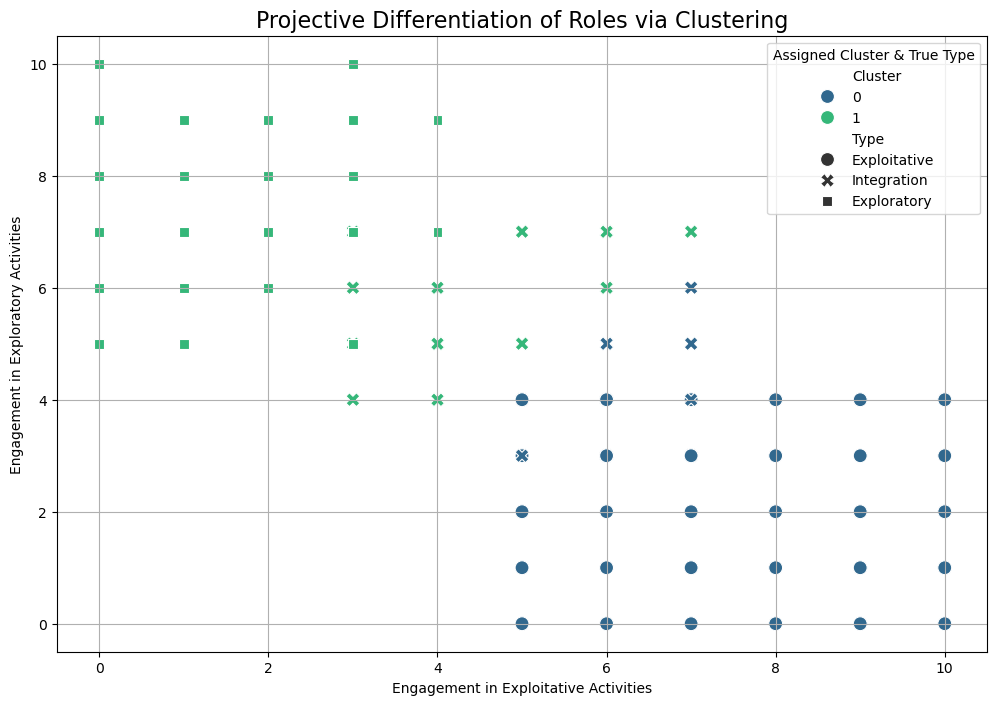

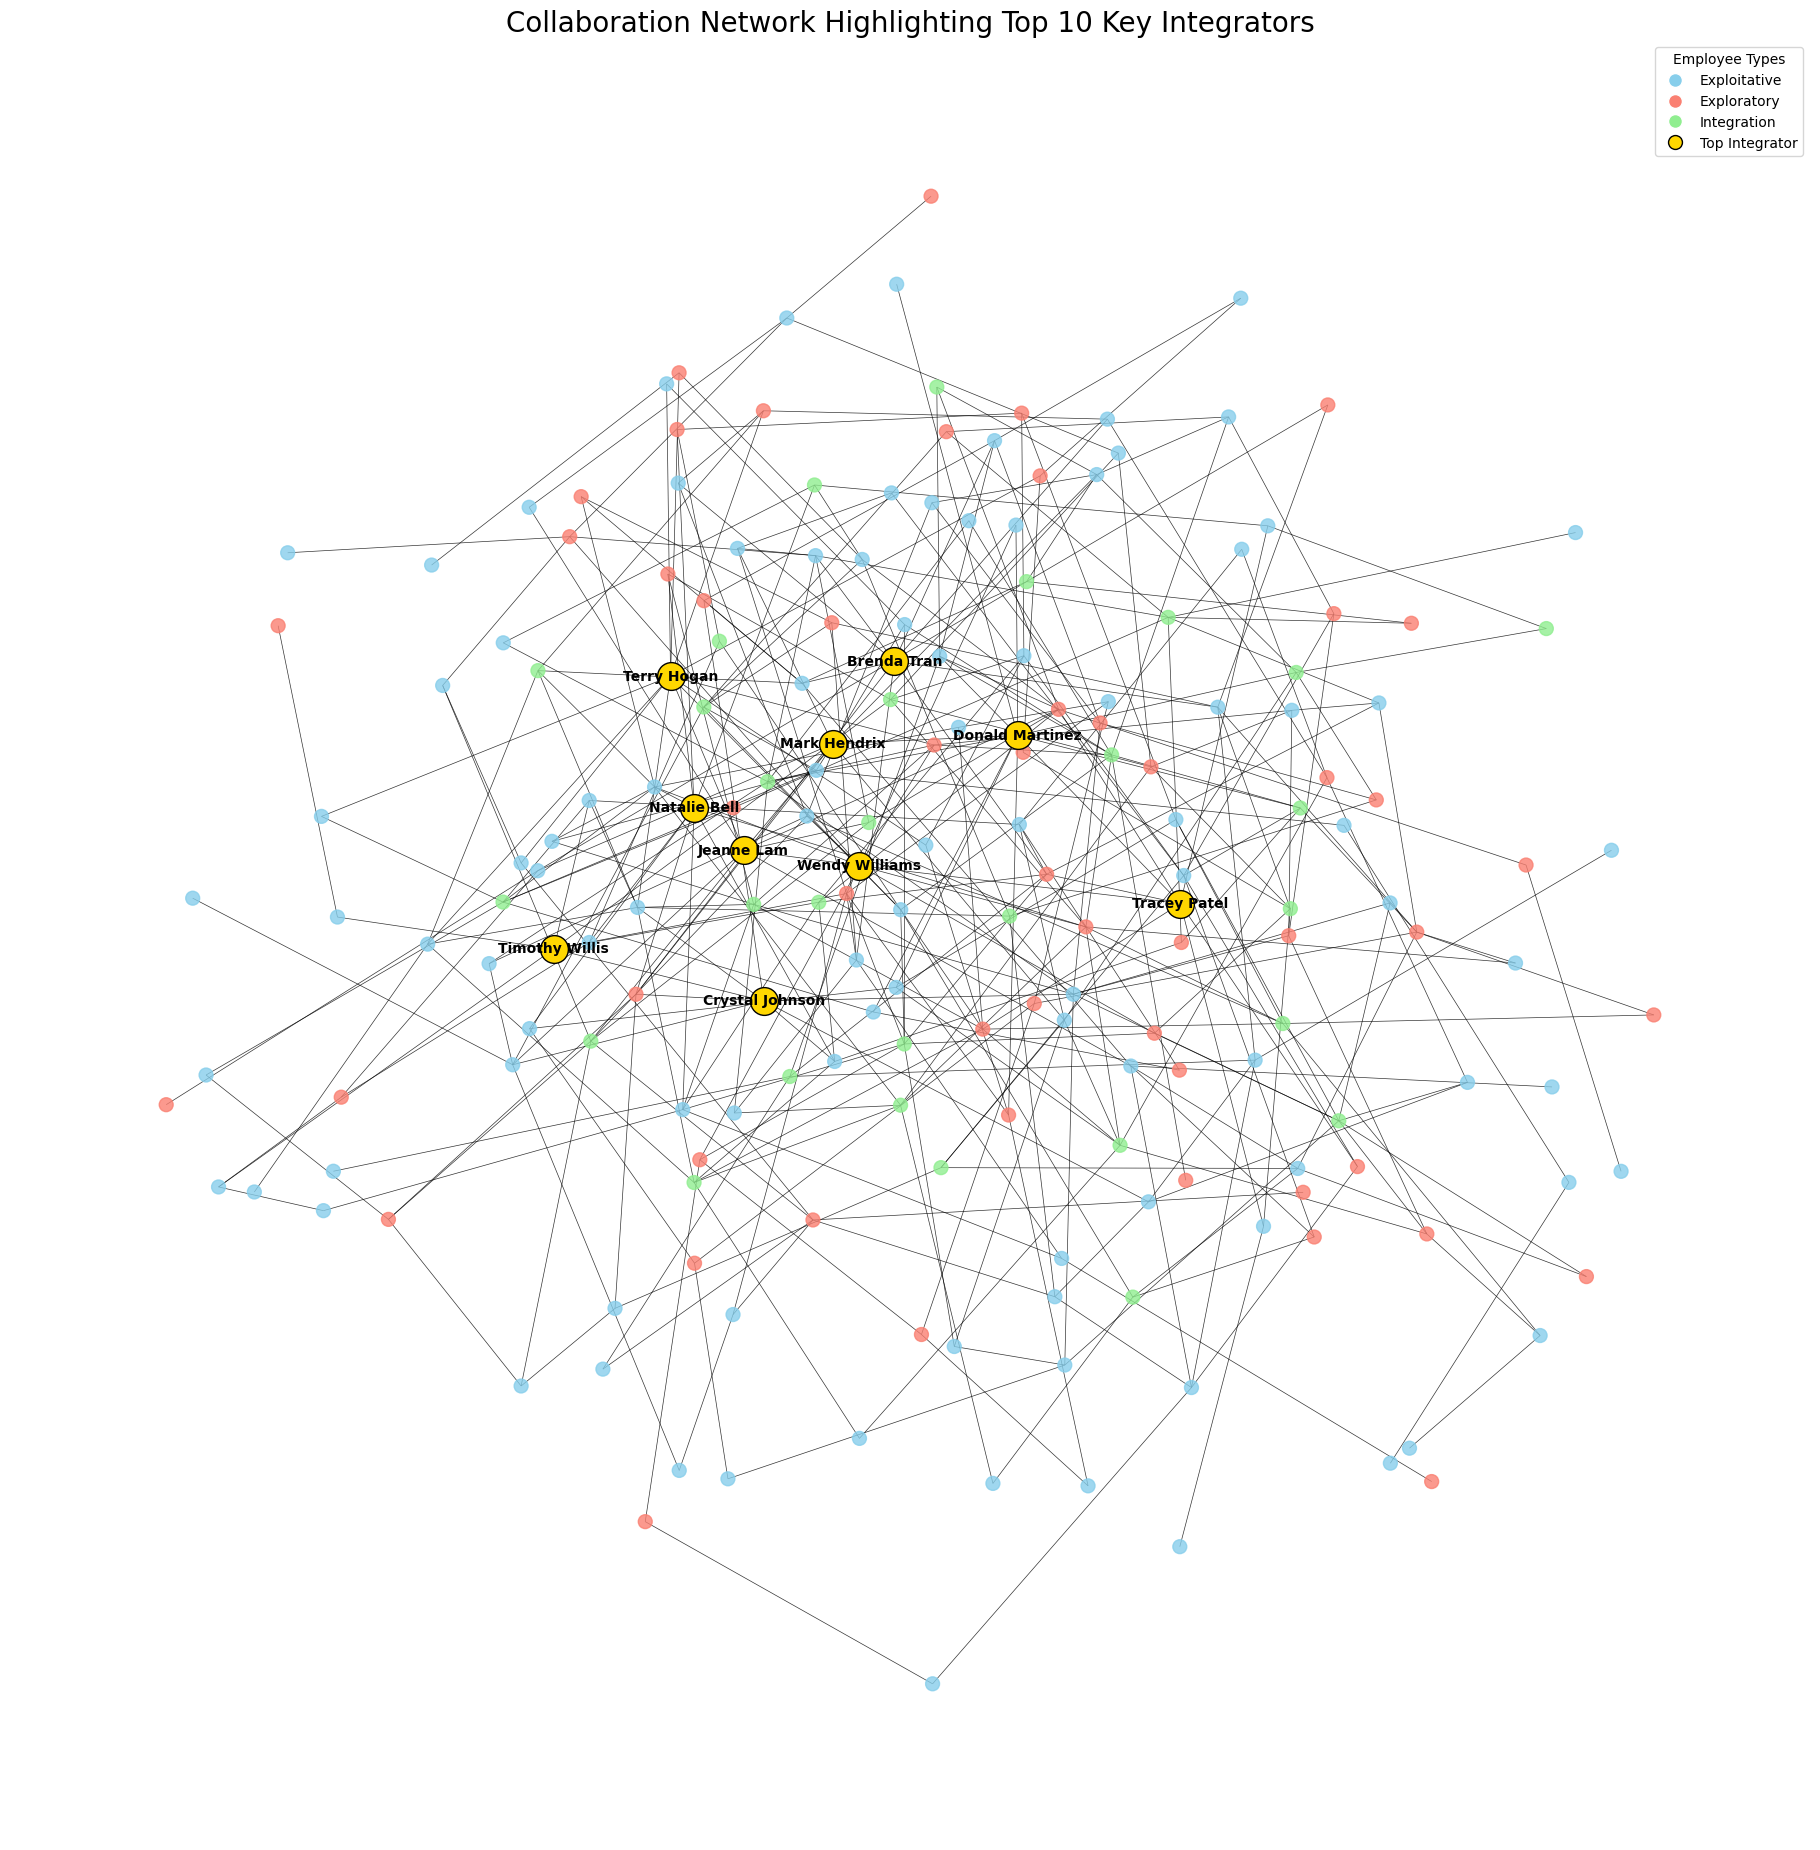

In [6]:
if __name__ == '__main__':
    employee_df, collaboration_data = simulate_ambidextrous_data()
    analyze_role_differentiation(employee_df)
    analyze_network_integration(employee_df, collaboration_data)
    
    if not employee_df.empty:
        # Select a manager from a non-strategy department for a more typical dashboard
        manager_pool = employee_df[employee_df['Department'] != 'Strategy']
        if not manager_pool.empty:
            manager = manager_pool.sample(1)['Name'].iloc[0]
            generate_manager_dashboard(manager, employee_df)
    
    print("✅ Full Ambidextrous Analysis complete.")